# Algorithm 1 and Figures

Requirements:

```
pip3 install numpy scipy matplotlib SciencePlots
````

In [8]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('science') # pip3 install SciencePlots


class RandInterval(np.random.RandomState):
    '''Uniform sampling from (a, b)'''
    def open(self, a, b):
        assert a < b
        c = a
        while c == a:
            c = a + self.random()*(b-a)
        return c

    
def vectorGenerator(seed=None):
    '''Algorithm 1 of the paper. Asserts the 5 conditions'''
    R = RandInterval(seed)
    Q1 = R.open(0, 1/2)
    Q2 = R.open(1/2, 1)
    Q3 = R.open(1-Q1, 1)
    P3 = R.open(1/2, 1)
    a = max((1-P3)*Q1, 1/2 - P3*Q3)
    b = min((1-P3)*Q2, P3*Q1)
    om = R.open(a, b)
    P2 = (om - Q1 * (1-P3)) / (Q2 - Q1)
    P1 = 1 - P3 - P2
    P = np.array([P1, P2, P3])
    Q = np.array([Q1, Q2, Q3])
    try:
        # Verify the 5 conditions explicitly
        assert 0<P1<1 and 0<P2<1 and 0<P3<1
        assert 0<Q1<1 and 0<Q2<1 and 0<Q3<1
        assert P1 + P2 + P3 == 1
        assert P1*Q1 + P2*Q2 + P3*Q3 > 1/2
        assert Q1<1/2 and Q2>1/2 and Q3>1/2
        assert Q3 + Q1>1
        assert P1*Q1 + P2*Q2 - P3*Q1 < 0
    except AssertionError as e:
        e.args = (f'\nP={P.round(3)}\nQ={Q.round(3)}',)
        raise
    return P, Q


def arbitraryGenerator(seed=None, n=4):
    '''Arbitrary generator for explanation purposes'''
    R = np.random.RandomState(seed)
    P = R.random(n)
    P /= P.sum()
    Q = R.random(n)
    return P, Q


def test_generator(many_times):
    '''Test (run) the vectorGenerator many times'''
    assert many_times > 0
    for _ in range(many_times):
        vectorGenerator(seed=None)
    print(f'{many_times} tests passed')
    return


test_generator(many_times=10**4)

10000 tests passed


In [52]:
import itertools
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from scipy.spatial import ConvexHull, convex_hull_plot_2d


class DataSource:

    def __init__(self, A, P, Q):
        assert len(A) == len(P) == len(Q)
        self.n = len(A)
        self.A = A
        self.P = P
        self.Q = Q
    
    def print(self):
        print(f'A={self.A.round(3)}')
        print(f'P={self.P.round(3)}')
        print(f'Q={self.Q.round(3)}')
        
    
    def err(self, F):
        P = self.P
        Q = self.Q
        return np.sum(F * (1-2*Q)) + np.sum(P * Q)
    
    def oppDiff(self, F):
        P = self.P
        Q = self.Q
        A = self.A
        f = lambda A: np.sum(F*Q*A)/np.sum(P*Q*A)
        return f(A) - f(1-A)
    
    def iter_soft(self, k=11):
        dim = np.linspace(0, 1, k)
        for f in itertools.product(dim, repeat=len(self.A)):
            F = np.array(f) * self.P
            yield F
    
    def iter_const(self):
        yield self.P*0
        yield self.P
    
    def iter_hard(self):
        for f in itertools.product([0,1], repeat=len(self.A)):
            F = np.array(f) * self.P
            yield F
    
    def metrics(self, F_iter):
        l = [(self.err(F), self.oppDiff(F)) for F in F_iter]
        return np.array(l)
    
    def the_plot(self, styles=(), r=None):
        self.print()
        P = self.P
        Q = self.Q

        #soft = cls.metrics(self.iter_soft())
        hard = self.metrics(self.iter_hard())
        const = self.metrics(self.iter_const())
        hull = hard[ConvexHull(hard).vertices]

        with plt.style.context(['grid', 'scatter', *styles]):
            plt.rcParams.update({
                #'font.size': 8, # Editors complained
                #'figure.figsize': (3.3, 2.5),
                'font.size': 9,
                'figure.figsize': (3.3, 2.4),
                'figure.dpi': 600,
                'font.family': 'serif',
                'font.serif': 'Times',
            })
            #plt.scatter(soft[:,0], soft[:,1], label='Soft', alpha=0.3)
            poly = Polygon(hull, label='Soft', alpha=0.25)
            plt.gca().add_patch(poly)
            plt.scatter(hard[:,0], hard[:,1], marker='.', label='Hard')
            plt.scatter(const[:,0], const[:,1], marker='x', label='Constant')
            plt.xlabel('error')
            plt.ylabel('opportunity-difference')
            plt.xlim((0,1))
            if r is not None and r > 0:
                x0 = const[:,0].min()
                y0 = const[const[:,0]==x0,1][0]
                if y0!=0:
                    print(y0)
                else:
                    plt.xlim((x0-r,x0+r))
                    plt.ylim((y0-r,y0+r))
            plt.legend()
            plt.show()
        return


A=[0 1 0 1]
P=[0.267 0.344 0.141 0.248]
Q=[0.893 0.896 0.126 0.207]


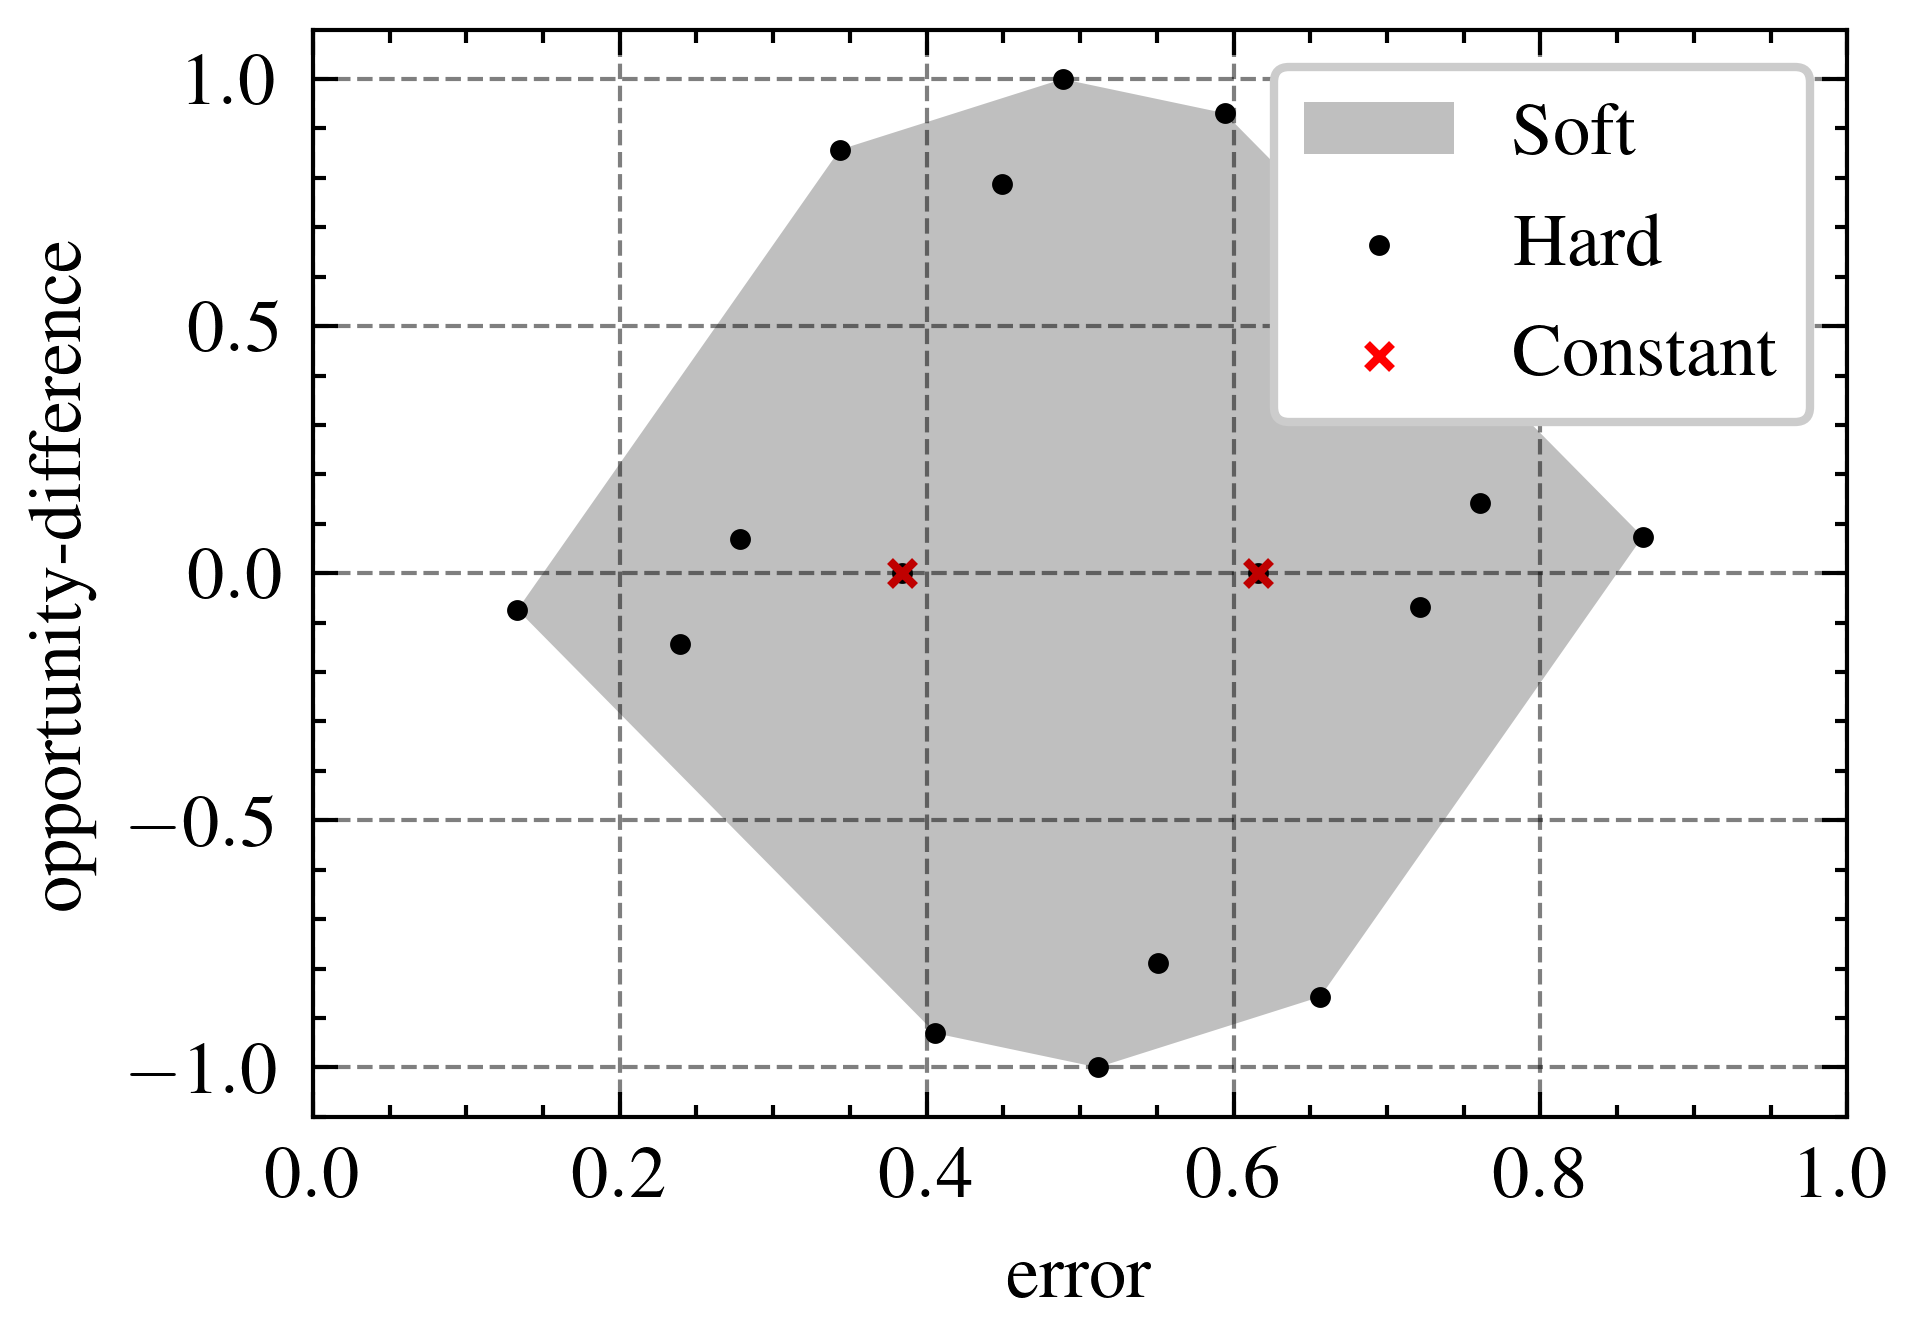

A=[0 0 1]
P=[0.131 0.096 0.772]
Q=[0.274 0.858 0.891]


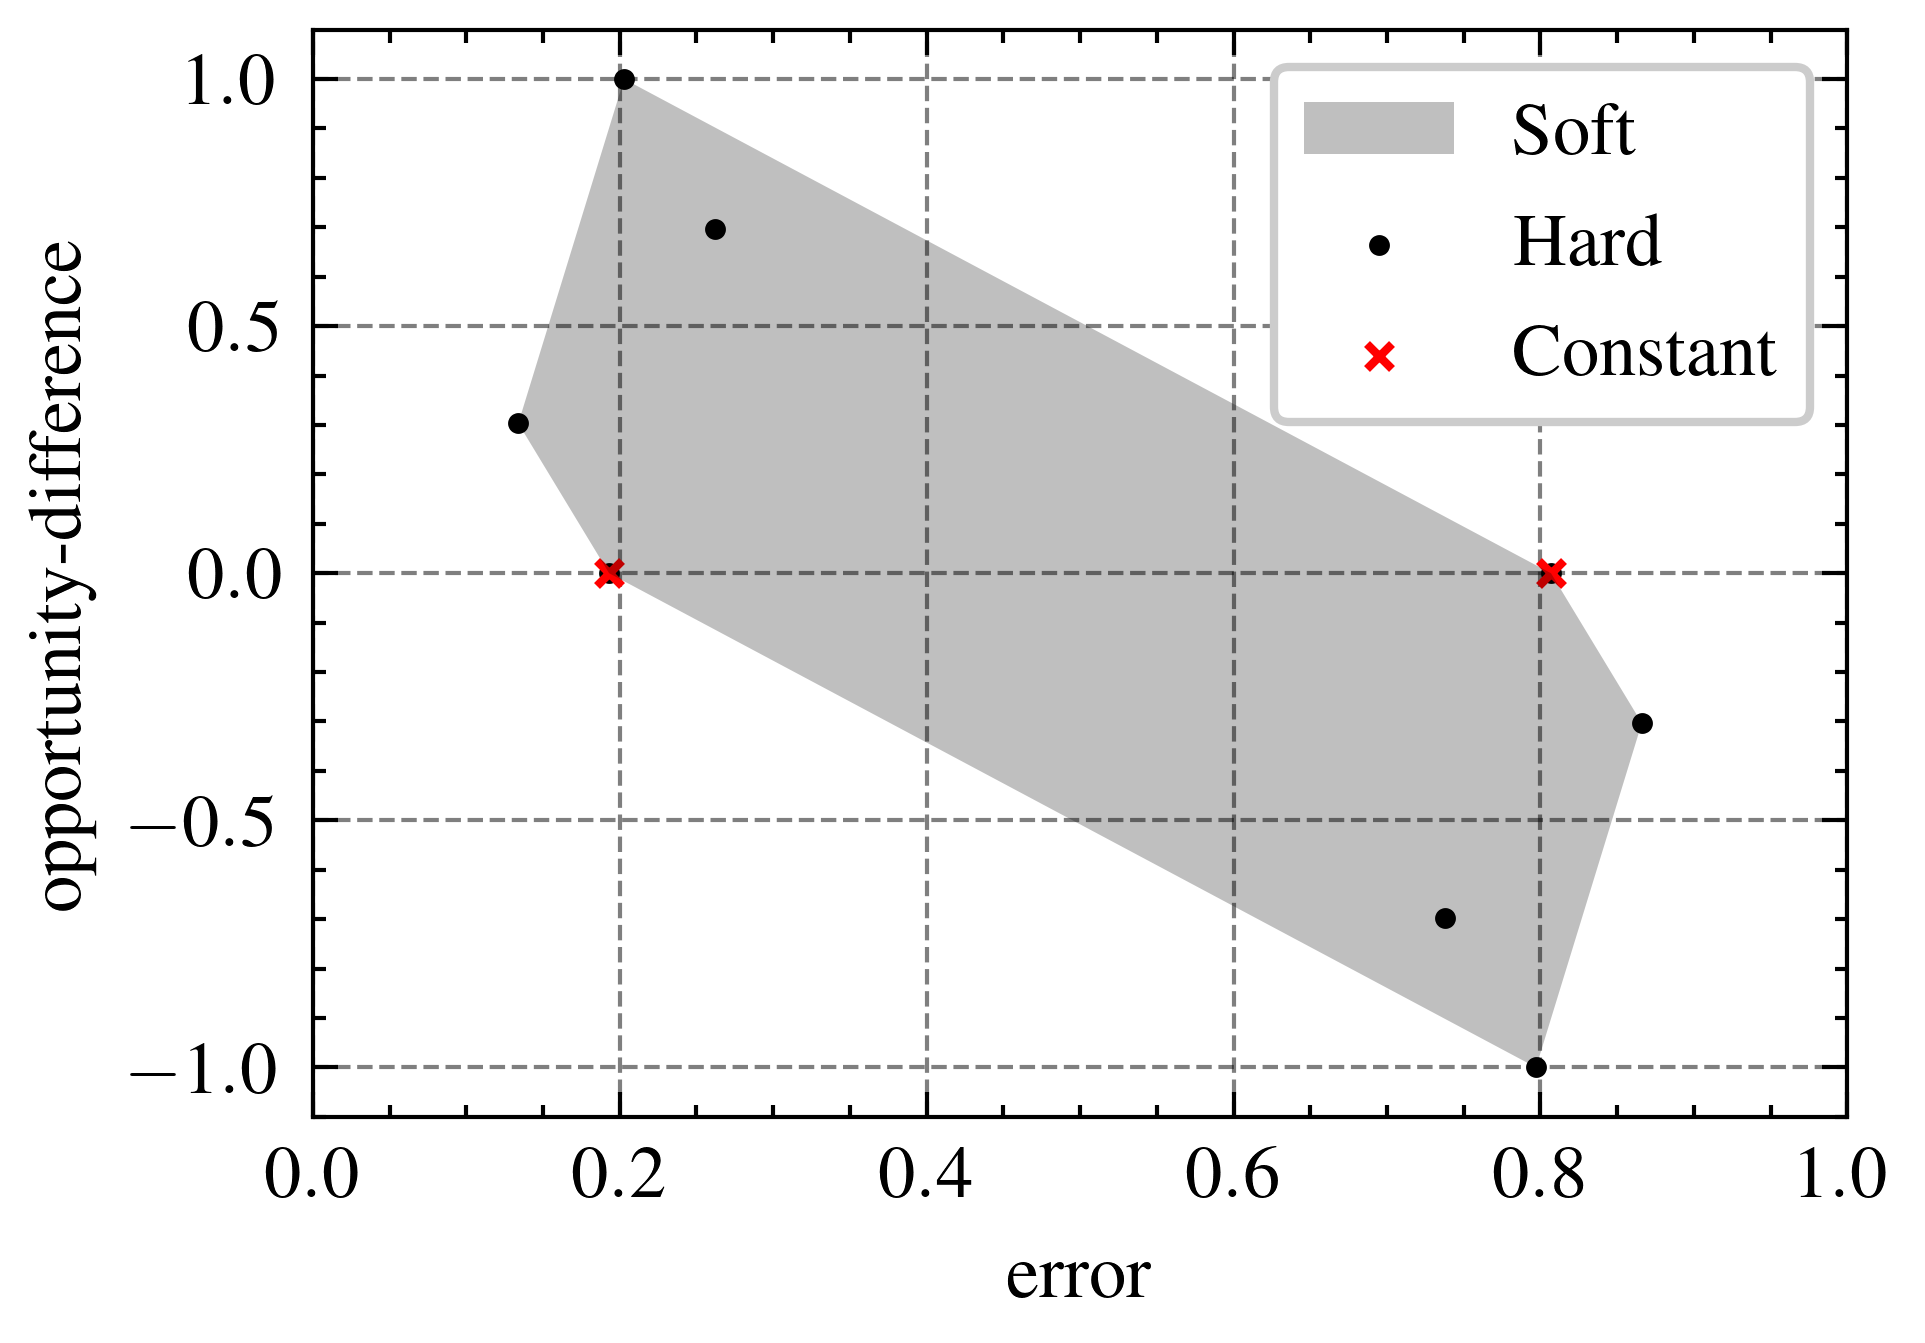

A=[0 1 0 1]
P=[0.375 0.25  0.125 0.25 ]
Q=[0.45 0.75 0.75 0.8 ]


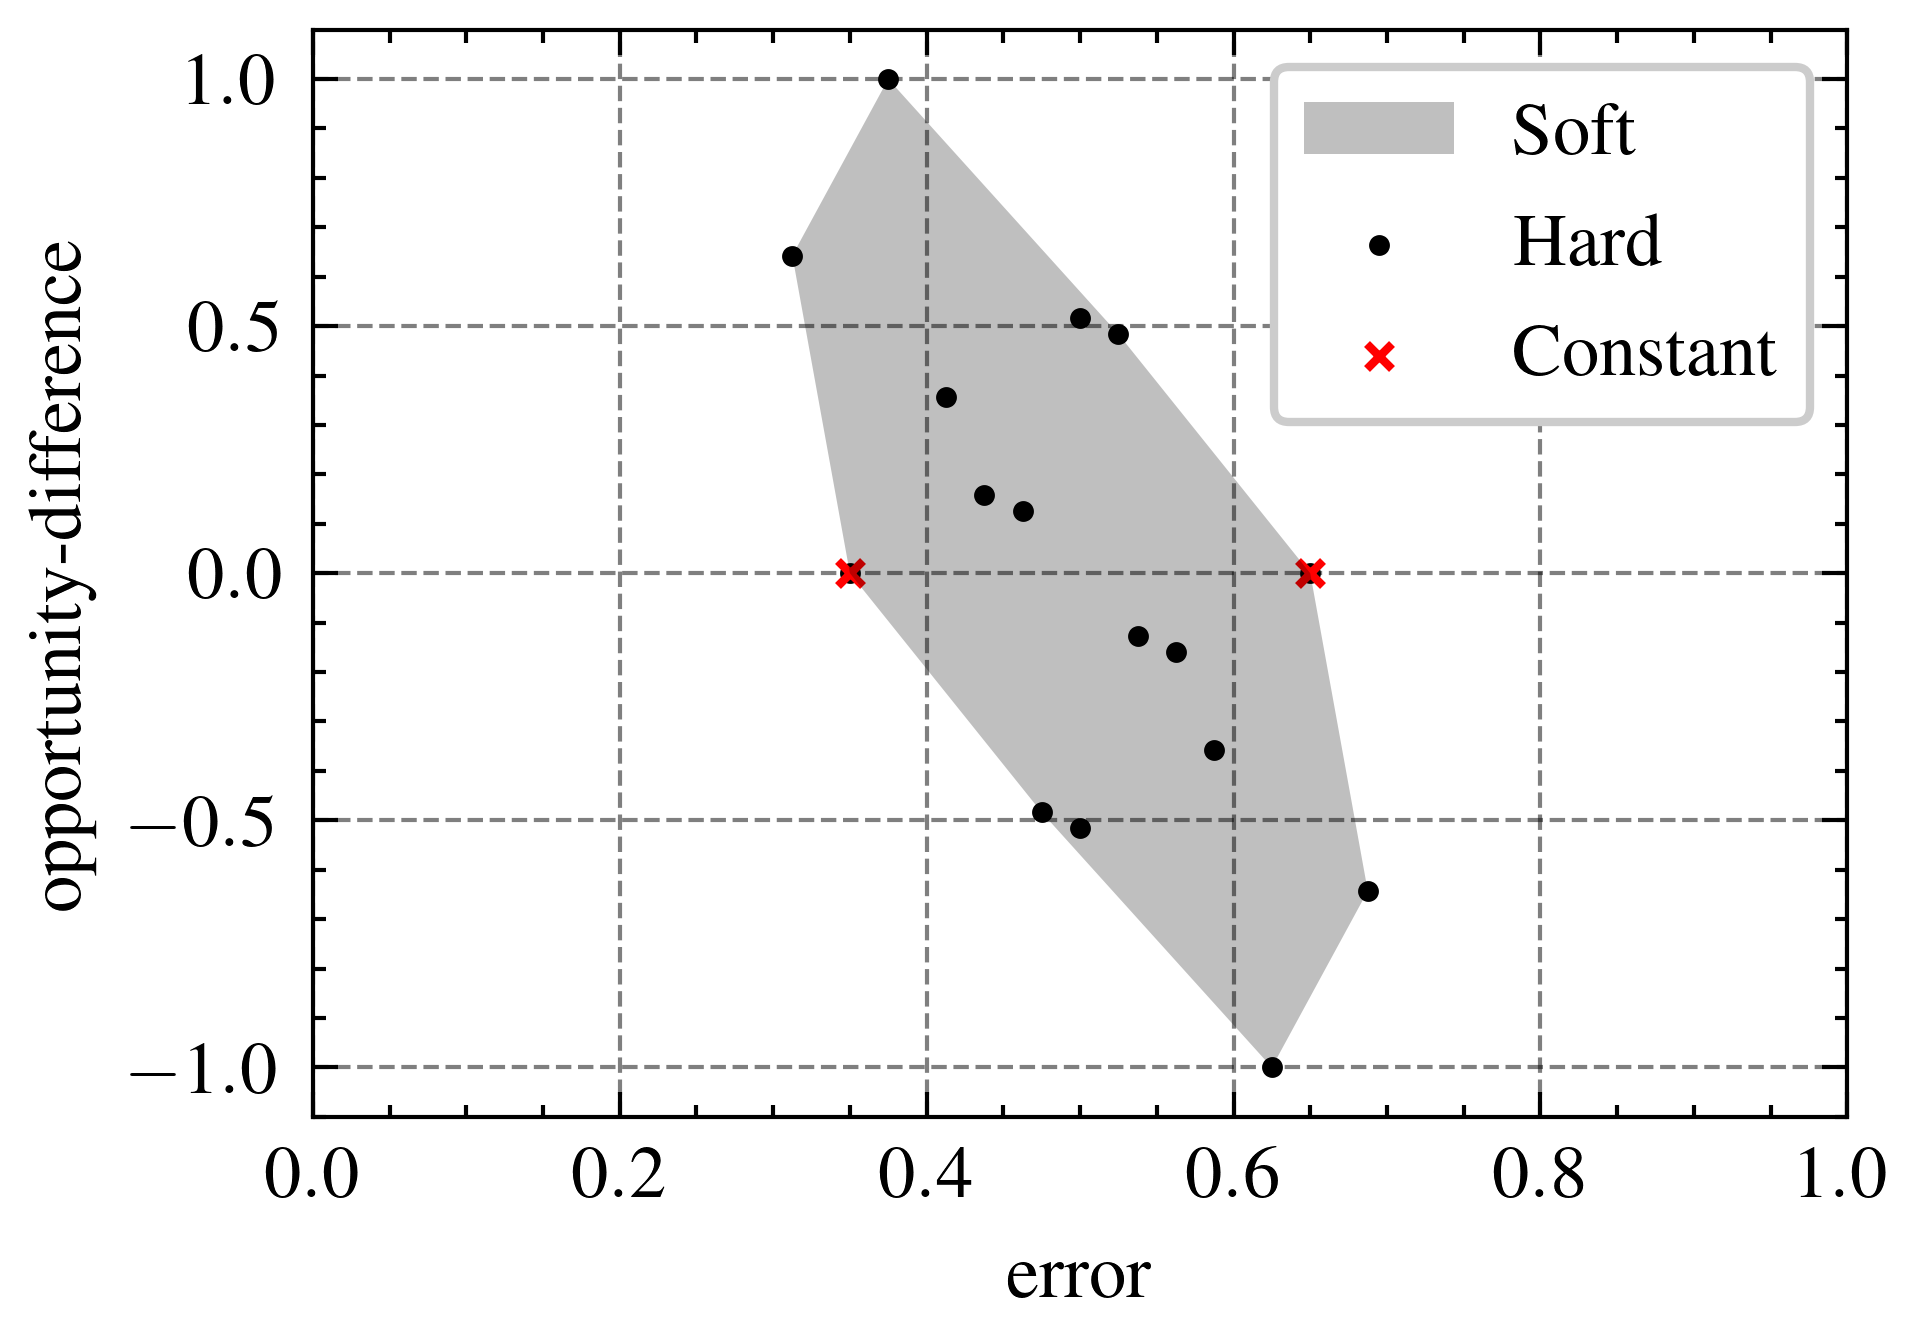

A=[0 1 0 1 0 1 0 1]
P=[0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
Q=[0.25 0.25 0.25 0.25 0.25 0.25 0.75 0.75]


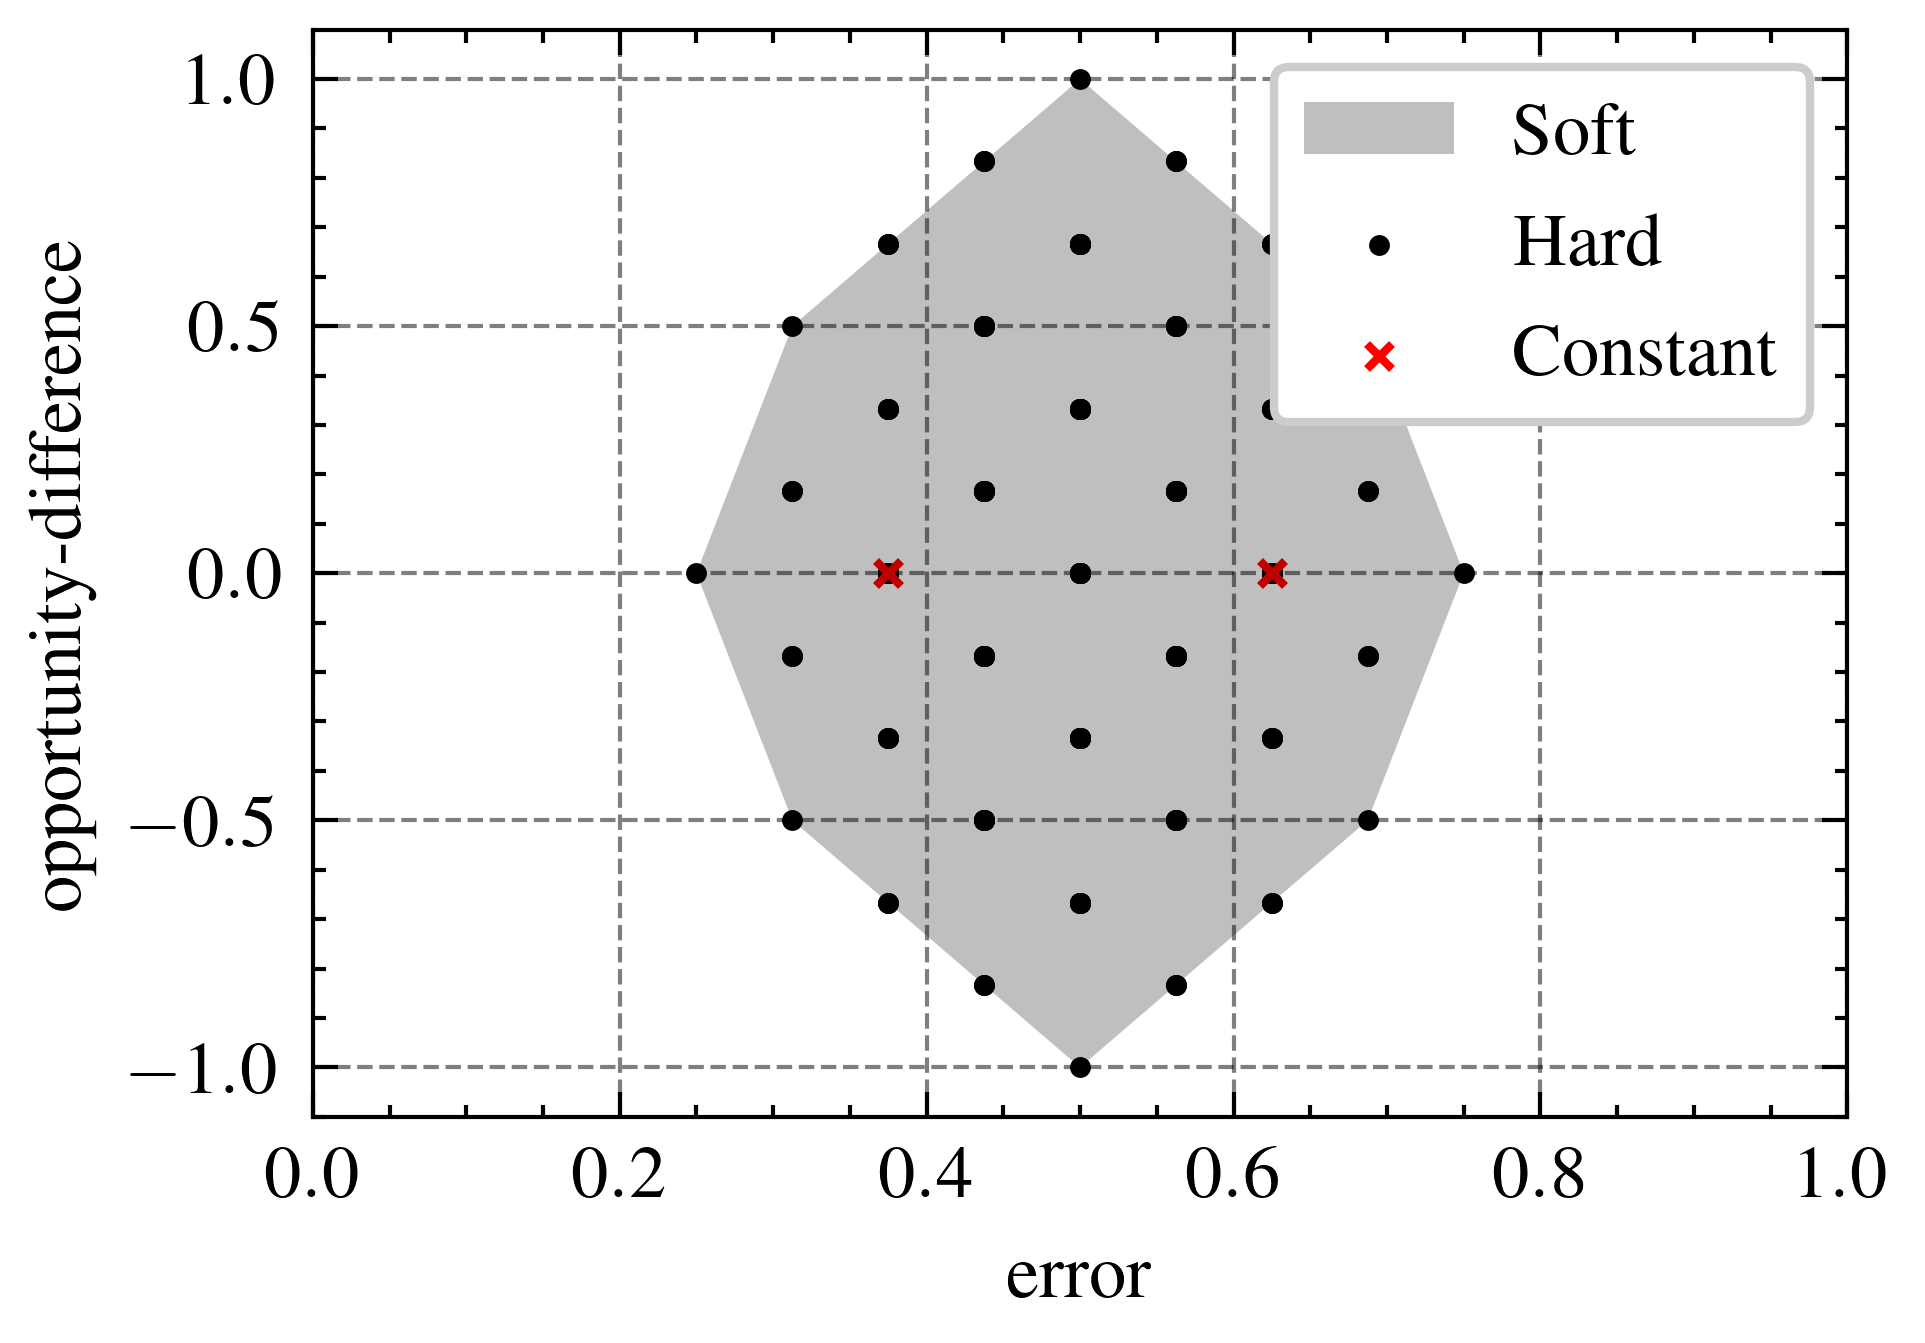

In [53]:

# Arbitrary non-example for Section "Strong impossibility result"
A = np.array([0, 1, 0, 1])
P, Q = arbitraryGenerator(seed=3, n=4)
DataSource(A, P, Q).the_plot(styles=['ieee'])

# Generated example for Theorem "Impossibility result"
A = np.array([0, 0, 1])
P, Q = vectorGenerator(seed=0)
DataSource(A, P, Q).the_plot(styles=['ieee'])

# First example we found. Appears as "Example 1"
A = np.array([ 0, 1, 0, 1])
P = np.array([ 3, 2, 1, 2]) / 8.
Q = np.array([ 9,15,15,16]) / 20.
DataSource(A, P, Q).the_plot(styles=['ieee'])


# Other arbitrary (not shown in paper)
A = np.array([ 0, 1, 0, 1, 0, 1, 0, 1])
P = np.array([ 1, 1, 1, 1, 1, 1, 1, 1]) / 8.
Q = np.array([ 1, 1, 1, 1, 1, 1, 3, 3]) / 4
DataSource(A, P, Q).the_plot(styles=['ieee'])